#**Problem Statement:**
In industry, prognostics and health management are key topics for anticipating asset state and avoiding downtime and breakdowns. Run-to-Failure simulation data from turbofan jet engines is included.

The C-MAPSS software was used to simulate engine degradation. Four separate sets of operational conditions and fault modes were simulated in four different ways. To characterize fault progression, record numerous sensor channels.
The Prognostics CoE at NASA Ames provided the data set.

The main goal is to predict the remaining useful life (RUL) of each engine. RUL is equivalent of number of flights remained for the engine after the last data point in the test dataset.


## **Approach:**
The problem statement is approached using classical machine learning tasks like Data Exploration, Data Cleaning, Feature Engineering, Model Building and Model Testing.

Tried 4 different machine learning algorithms:
1. k-Neares Neighbors (KNNs).
2. Support Vector Machine (SVM).
3. Random Forest.
4. Long-Short Term Memory (LSTM) Network.

and comapred the resultsd of each algorithm.

In [92]:
# Import the core libraries required for exploration and preprocessing
import time
import numpy as np
import pandas as pd

#ML Libraries
import sklearn
import tensorflow as tf
from sklearn.svm import SVR
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout

# For Visualization
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots

#Other Libraries
import warnings
from importlib import reload
from IPython.display import display, HTML

reload(plt)
warnings.filterwarnings('ignore')

*Defining column names for the turbofan data features.*

In [93]:
index_names = ['engine', 'cycle']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names=[ "(Fan inlet temperature) (◦R)",
"(LPC outlet temperature) (◦R)",
"(HPC outlet temperature) (◦R)",
"(LPT outlet temperature) (◦R)",
"(Fan inlet Pressure) (psia)",
"(bypass-duct pressure) (psia)",
"(HPC outlet pressure) (psia)",
"(Physical fan speed) (rpm)",
"(Physical core speed) (rpm)",
"(Engine pressure ratio(P50/P2)",
"(HPC outlet Static pressure) (psia)",
"(Ratio of fuel flow to Ps30) (pps/psia)",
"(Corrected fan speed) (rpm)",
"(Corrected core speed) (rpm)",
"(Bypass Ratio) ",
"(Burner fuel-air ratio)",
"(Bleed Enthalpy)",
"(Required fan speed)",
"(Required fan conversion speed)",
"(High-pressure turbines Cool air flow)",
"(Low-pressure turbines Cool air flow)" ]
col_names = index_names + setting_names + sensor_names

*Importing the training, test, and validation datasets*

In [94]:
df_train = pd.read_csv(('/content/train_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test = pd.read_csv(('/content/test_FD001.txt'), sep='\s+', header=None, names=col_names)
df_test_RUL = pd.read_csv(('/content/RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

In [95]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   20631 non-null  int64  
 1   cycle                                    20631 non-null  int64  
 2   setting_1                                20631 non-null  float64
 3   setting_2                                20631 non-null  float64
 4   setting_3                                20631 non-null  float64
 5   (Fan inlet temperature) (◦R)             20631 non-null  float64
 6   (LPC outlet temperature) (◦R)            20631 non-null  float64
 7   (HPC outlet temperature) (◦R)            20631 non-null  float64
 8   (LPT outlet temperature) (◦R)            20631 non-null  float64
 9   (Fan inlet Pressure) (psia)              20631 non-null  float64
 10  (bypass-duct pressure) (psia)            20631

In [96]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13096 entries, 0 to 13095
Data columns (total 26 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   engine                                   13096 non-null  int64  
 1   cycle                                    13096 non-null  int64  
 2   setting_1                                13096 non-null  float64
 3   setting_2                                13096 non-null  float64
 4   setting_3                                13096 non-null  float64
 5   (Fan inlet temperature) (◦R)             13096 non-null  float64
 6   (LPC outlet temperature) (◦R)            13096 non-null  float64
 7   (HPC outlet temperature) (◦R)            13096 non-null  float64
 8   (LPT outlet temperature) (◦R)            13096 non-null  float64
 9   (Fan inlet Pressure) (psia)              13096 non-null  float64
 10  (bypass-duct pressure) (psia)            13096

*To obtain a detailed statistical summary of df_train DataFrame, including descriptive statistics for numerical and categorical columns, I have used the .describe() method with include='all'. This method computes various summary statistics such as count, mean, standard deviation, minimum, maximum, and quartiles for numeric columns. For categorical columns, it provides counts of unique values, the most frequent value, and its frequency.*

In [97]:
df_train.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
engine,20631.0,51.506568,2.922763e+01,1.0000,26.0000,52.0000,77.0000,100.0000
cycle,20631.0,108.807862,6.888099e+01,1.0000,52.0000,104.0000,156.0000,362.0000
setting_1,20631.0,-0.000009,2.187313e-03,-0.0087,-0.0015,0.0000,0.0015,0.0087
setting_2,20631.0,0.000002,2.930621e-04,-0.0006,-0.0002,0.0000,0.0003,0.0006
setting_3,20631.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000
(Fan inlet temperature) (◦R),20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
(LPC outlet temperature) (◦R),20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
(HPC outlet temperature) (◦R),20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
(LPT outlet temperature) (◦R),20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
(Fan inlet Pressure) (psia),20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200


*Setting up a heatmap using Seaborn to visualize the correlation matrix (df_cluster2) of df_train DataFrame.*

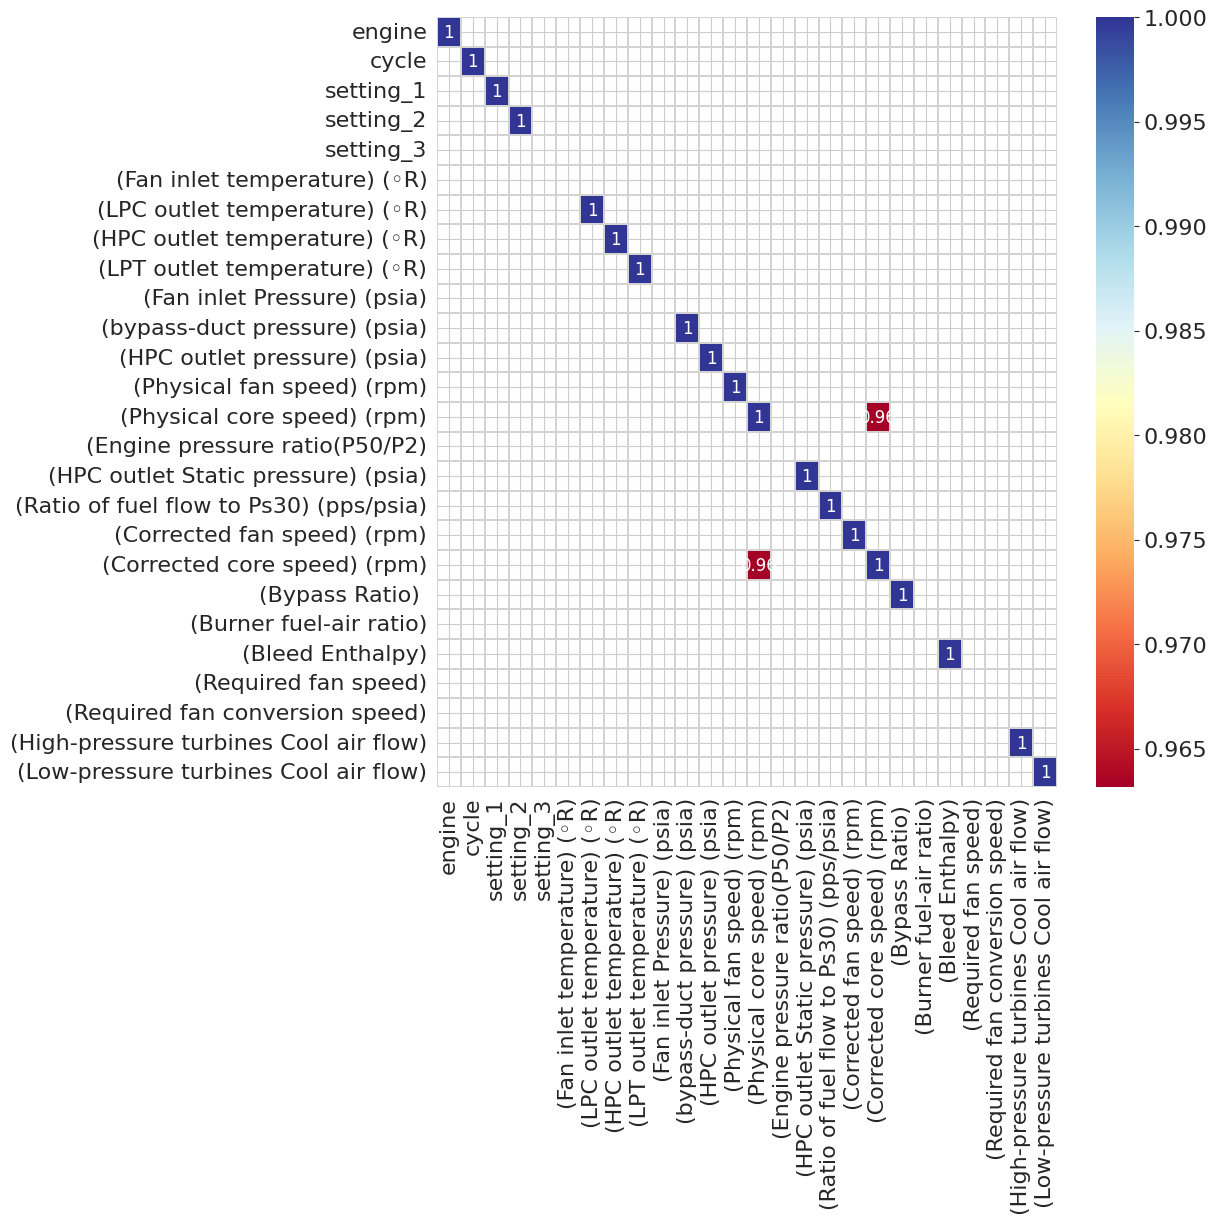

In [98]:
plt.figure(figsize=(10,10))
threshold = 0.90
sns.set_style("whitegrid", {"axes.facecolor": ".0"})
df_cluster2 = df_train.corr()
mask = df_cluster2.where((abs(df_cluster2) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster2,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2,
            linecolor='lightgrey').set_facecolor('white')

*The code effectively identifies and drops columns with constant values from df_train and df_test DataFrames. It ensures that these columns, which do not contribute variability or predictive power, are removed before further analysis or modeling steps.*

In [99]:
# drop the sensors wiith constant values
sens_const_values = []
for feature in list(setting_names + sensor_names):
    try:
        if df_train[feature].min()==df_train[feature].max():
            sens_const_values.append(feature)
    except:
        pass

print(sens_const_values)
df_train.drop(sens_const_values,axis=1,inplace=True)
df_test.drop(sens_const_values,axis=1,inplace=True)

['setting_3', '(Fan inlet temperature) (◦R)', '(Fan inlet Pressure) (psia)', '(Engine pressure ratio(P50/P2)', '(Burner fuel-air ratio)', '(Required fan speed)', '(Required fan conversion speed)']


*Dropping highly correlated features from df_train and df_test DataFrames, helping to reduce multicollinearity and potentially improve the performance and interpretability of machine learning models. Validating the results to ensure that essential information is retained while eliminating redundant features.*

In [100]:
# drop all but one of the highly correlated features
cor_matrix = df_train.corr().abs()
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(bool))
corr_features = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(corr_features)
df_train.drop(corr_features,axis=1,inplace=True)
df_test.drop(corr_features,axis=1,inplace=True)

['(Corrected core speed) (rpm)']


In [101]:
#Remaining Features
list(df_train)

['engine',
 'cycle',
 'setting_1',
 'setting_2',
 '(LPC outlet temperature) (◦R)',
 '(HPC outlet temperature) (◦R)',
 '(LPT outlet temperature) (◦R)',
 '(bypass-duct pressure) (psia)',
 '(HPC outlet pressure) (psia)',
 '(Physical fan speed) (rpm)',
 '(Physical core speed) (rpm)',
 '(HPC outlet Static pressure) (psia)',
 '(Ratio of fuel flow to Ps30) (pps/psia)',
 '(Corrected fan speed) (rpm)',
 '(Bypass Ratio) ',
 '(Bleed Enthalpy)',
 '(High-pressure turbines Cool air flow)',
 '(Low-pressure turbines Cool air flow)']

*To check for missing data (NaN values) across all features in the df_train DataFrame by iterating through each feature and count the number of NaN values using the .isna() method. It helps identify columns that may require data imputation or further investigation to handle missing values appropriately before proceeding with modeling or analysis tasks.*

In [102]:
features = list(df_train.columns)
for feature in features:
    print(feature + " - " + str(len(df_train[df_train[feature].isna()])))

engine - 0
cycle - 0
setting_1 - 0
setting_2 - 0
(LPC outlet temperature) (◦R) - 0
(HPC outlet temperature) (◦R) - 0
(LPT outlet temperature) (◦R) - 0
(bypass-duct pressure) (psia) - 0
(HPC outlet pressure) (psia) - 0
(Physical fan speed) (rpm) - 0
(Physical core speed) (rpm) - 0
(HPC outlet Static pressure) (psia) - 0
(Ratio of fuel flow to Ps30) (pps/psia) - 0
(Corrected fan speed) (rpm) - 0
(Bypass Ratio)  - 0
(Bleed Enthalpy) - 0
(High-pressure turbines Cool air flow) - 0
(Low-pressure turbines Cool air flow) - 0


*Computing the Remaining Useful Life (RUL) for each engine based on the maximum cycle (cycle column) observed for each engine in the df_train DataFrame. This process effectively computes the Remaining Useful Life (RUL) for each engine based on the maximum observed cycle (life) per engine. It's a crucial step in predictive maintenance to understand how close each engine is to failure based on historical data.*

In [103]:
df_train_RUL = df_train.groupby(['engine']).agg({'cycle':'max'})
df_train_RUL.rename(columns={'cycle':'life'},inplace=True)
df_train=df_train.merge(df_train_RUL,how='left',on=['engine'])
df_train['RUL']=df_train['life']-df_train['cycle']
df_train.drop(['life'],axis=1,inplace=True)
df_train_RUL.head()

,life
engine,
1,192
2,287
3,179
4,189
5,269


*This operation effectively ensures that any RUL values exceeding 125 are set to 125 in the df_train DataFrame. It might be useful in scenarios where we have to limit or cap certain values to prevent outliers from disproportionately affecting the analysis or models.*

In [104]:
df_train['RUL'][df_train['RUL']>125]=125
df_train.head(20)

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),RUL
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190,125
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236,125
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442,125
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739,125
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044,125
5,1,6,-0.0043,-0.0001,642.10,1584.47,1398.37,21.61,554.67,2388.02,9049.68,47.16,521.68,2388.03,8.4108,391,38.98,23.3669,125
6,1,7,0.0010,0.0001,642.48,1592.32,1397.77,21.61,554.34,2388.02,9059.13,47.36,522.32,2388.03,8.3974,392,39.10,23.3774,125
7,1,8,-0.0034,0.0003,642.56,1582.96,1400.97,21.61,553.85,2388.00,9040.80,47.24,522.47,2388.03,8.4076,391,38.97,23.3106,125
8,1,9,0.0008,0.0001,642.12,1590.98,1394.80,21.61,553.69,2388.05,9046.46,47.29,521.79,2388.05,8.3728,392,39.05,23.4066,125
9,1,10,-0.0033,0.0001,641.71,1591.24,1400.46,21.61,553.59,2388.05,9051.70,47.03,521.79,2388.06,8.4286,393,38.95,23.4694,125


*Creating subplots which represents the sensor outputs (plot_items) over the Remaining Useful Life (RUL) for different engines in your dataset. This effectively visualize the sensor outputs over RUL for different engines, aiding in understanding trends and patterns in the data.*

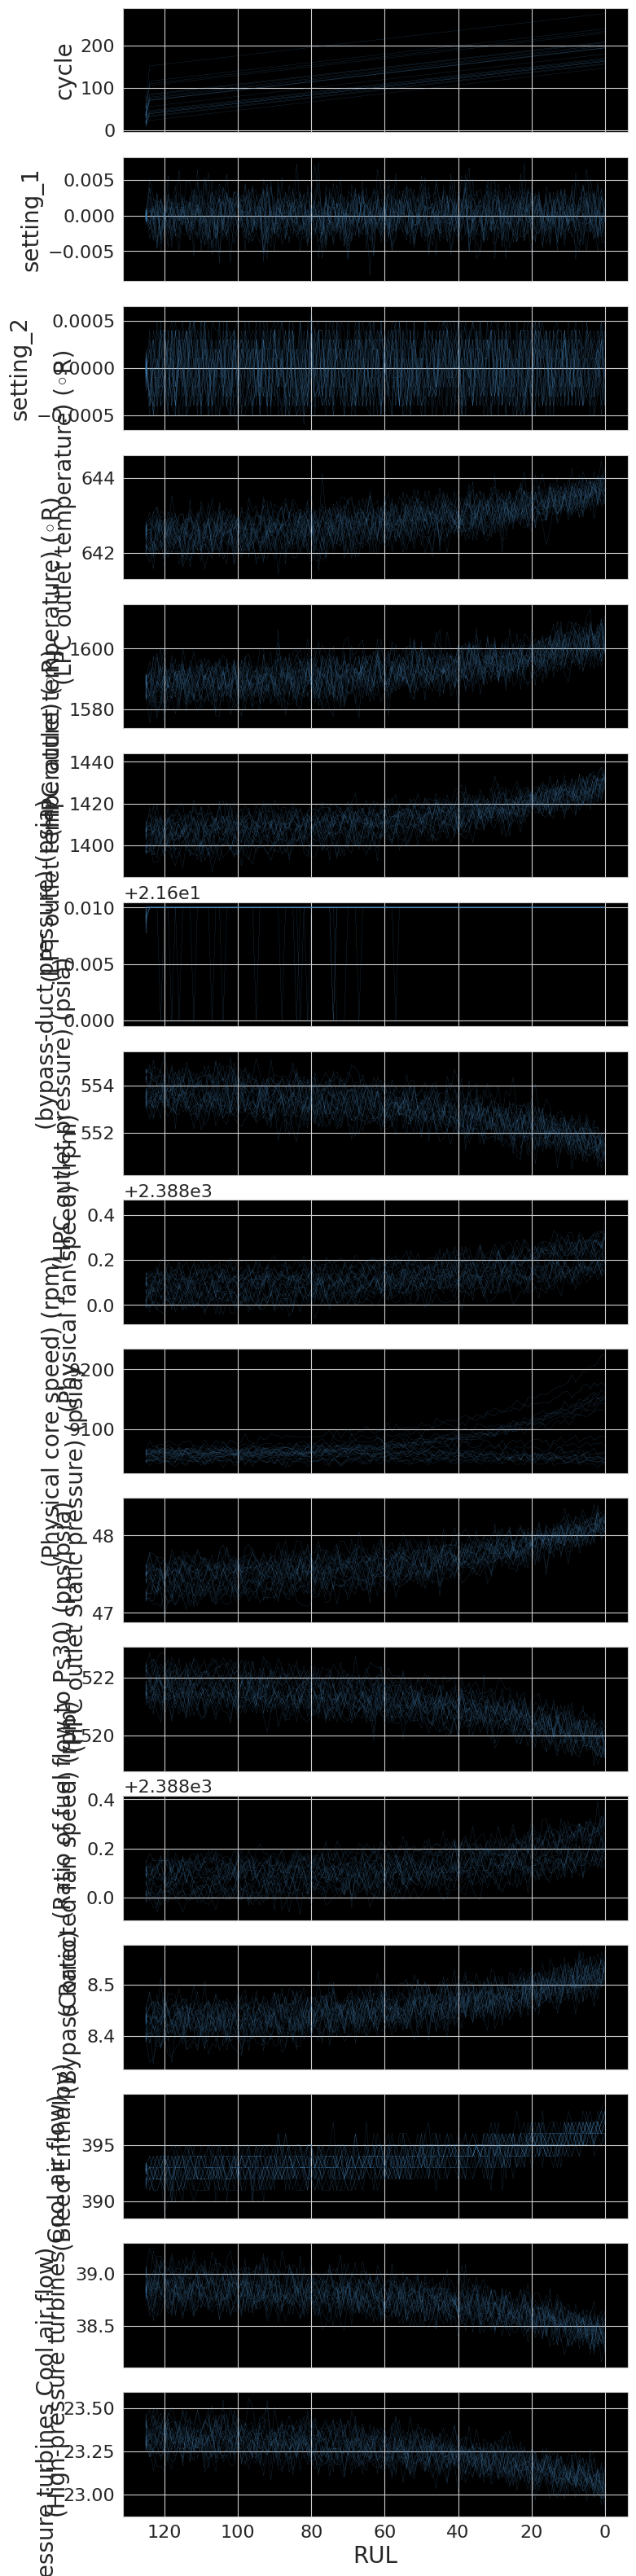

In [105]:
#plotting sensor outputs for all sensors
plt.rcParams['figure.figsize']=8,40
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 8
plt.rcParams['lines.linewidth'] = 0.1
plot_items = list(df_train.columns)[1:-1]
fig,ax = plt.subplots(len(plot_items),sharex=True)
ax[0].invert_xaxis()

engines = list(df_train['engine'].unique())

for engine in engines[10:30]:
    for i,item in enumerate(plot_items):
        f = sns.lineplot(data=df_train[df_train['engine']==engine],x='RUL',y=item,color='steelblue',ax=ax[i],
                        )

The smooth_function defined utilizes the Savitzky-Golay filter from scipy.signal to smooth the input data x using specified parameters window and order. This function provides a straightforward way to apply smoothing using the Savitzky-Golay filter, useful for preprocessing data in various applications such as signal processing or preparing data for machine learning models.

In [106]:
def smooth_function(x,window=15,order=3):
    return signal.savgol_filter(x,window,order)

*The backward_regression function implements a backward elimination method for feature selection using Ordinary Least Squares (OLS) regression. This function provides a systematic approach to feature selection based on statistical significance, leveraging OLS regression to iteratively remove less relevant features until a stopping criterion (threshold_out) is met.*

In [107]:
Selected_Features = []

def backward_regression(X, y, initial_list=[], threshold_out=0.05, verbose=True):
    included = list(X.columns)
    while True:
        changed = False
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max()
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print(f"worst_feature : {worst_feature}, {worst_pval} ")
        if not changed:
            break
    Selected_Features.append(included)
    print(f"\nSelected Features:\n{Selected_Features[0]}")

# Application of the backward regression function on our training data
X = df_train.iloc[:,1:-1]
y = df_train.iloc[:,-1]
backward_regression(X, y)

worst_feature : setting_1, 0.3590854598797697 
worst_feature : setting_2, 0.18806323573828398 

Selected Features:
['cycle', '(LPC outlet temperature) (◦R)', '(HPC outlet temperature) (◦R)', '(LPT outlet temperature) (◦R)', '(bypass-duct pressure) (psia)', '(HPC outlet pressure) (psia)', '(Physical fan speed) (rpm)', '(Physical core speed) (rpm)', '(HPC outlet Static pressure) (psia)', '(Ratio of fuel flow to Ps30) (pps/psia)', '(Corrected fan speed) (rpm)', '(Bypass Ratio) ', '(Bleed Enthalpy)', '(High-pressure turbines Cool air flow)', '(Low-pressure turbines Cool air flow)']


In [108]:
Selected_Features

[['cycle',
  '(LPC outlet temperature) (◦R)',
  '(HPC outlet temperature) (◦R)',
  '(LPT outlet temperature) (◦R)',
  '(bypass-duct pressure) (psia)',
  '(HPC outlet pressure) (psia)',
  '(Physical fan speed) (rpm)',
  '(Physical core speed) (rpm)',
  '(HPC outlet Static pressure) (psia)',
  '(Ratio of fuel flow to Ps30) (pps/psia)',
  '(Corrected fan speed) (rpm)',
  '(Bypass Ratio) ',
  '(Bleed Enthalpy)',
  '(High-pressure turbines Cool air flow)',
  '(Low-pressure turbines Cool air flow)']]

In [109]:
feature_names = Selected_Features[0]
np.shape(X)

(20631, 17)

*Evaluating the performance of machine learning models using R-squared (coefficient of determination), RMSE (Root Mean Squared Error), and timing metrics. This setup allows to systematically track and compare the performance of different models based on key metrics and timing information, facilitating effective evaluation.*

In [110]:
model_performance = pd.DataFrame(columns=['r-Squared','RMSE','total time'])
model_performance = pd.DataFrame(columns=['R2','RMSE', 'time to train','time to predict','total time'])

def R_squared(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - SS_res/(SS_tot + K.epsilon())

*Extracting the maximum cycle number (life) for each engine from the df_test DataFrame and then filtering it out the rows where the current cycle (cycle) equals the maximum cycle (life) for that engine. This approach ensures that df_test_max contains only the rows representing the last cycle for each engine in the df_test DataFrame.*

In [111]:
df_test_cycle = df_test.groupby(['engine']).agg({'cycle':'max'})
df_test_cycle.rename(columns={'cycle':'life'},inplace=True)
df_test_max = df_test.merge(df_test_cycle,how='left',on=['engine'])
df_test_max = df_test_max[(df_test_max['cycle']==df_test_max['life'])]
df_test_max.drop(['life'],axis=1,inplace=True)
df_test_max

,engine,cycle,setting_1,setting_2,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
30,1,31,-0.0006,0.0004,642.58,1581.22,1398.91,21.61,554.42,2388.08,9056.40,47.23,521.79,2388.06,8.4024,393,38.81,23.3552
79,2,49,0.0018,-0.0001,642.55,1586.59,1410.83,21.61,553.52,2388.10,9044.77,47.67,521.74,2388.09,8.4505,391,38.81,23.2618
205,3,126,-0.0016,0.0004,642.88,1589.75,1418.89,21.61,552.59,2388.16,9049.26,47.88,520.83,2388.14,8.4119,395,38.93,23.2740
311,4,106,0.0012,0.0004,642.78,1594.53,1406.88,21.61,552.64,2388.13,9051.30,47.65,521.88,2388.11,8.4634,395,38.58,23.2581
409,5,98,-0.0013,-0.0004,642.27,1589.94,1419.36,21.61,553.29,2388.10,9053.99,47.46,521.00,2388.15,8.4362,394,38.75,23.4117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12545,96,97,-0.0006,0.0003,642.30,1590.88,1397.94,21.61,553.99,2388.03,9062.41,47.14,522.30,2388.01,8.4110,391,38.96,23.4606
12679,97,134,0.0013,-0.0001,642.59,1582.96,1410.92,21.61,554.05,2388.06,9076.36,47.38,521.58,2388.06,8.4500,395,38.61,23.2953
12800,98,121,0.0017,0.0001,642.68,1599.51,1415.47,21.61,553.44,2388.13,9062.34,47.66,521.53,2388.09,8.4235,394,38.76,23.3608
12897,99,97,0.0047,-0.0000,642.00,1585.03,1397.98,21.61,554.75,2388.01,9067.16,47.26,521.82,2388.02,8.4003,391,38.95,23.3595


*Prepare training and testing datasets (X_train, y_train for training and X_test, y_test for testing) using selected features (feature_names).*

In [112]:
X_train = df_train[feature_names]
y_train = df_train.iloc[:,-1]
X_test = df_test_max[feature_names]
y_test = df_test_RUL.iloc[:,-1]
X_train.head(20)

,cycle,(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(bypass-duct pressure) (psia),(HPC outlet pressure) (psia),(Physical fan speed) (rpm),(Physical core speed) (rpm),(HPC outlet Static pressure) (psia),(Ratio of fuel flow to Ps30) (pps/psia),(Corrected fan speed) (rpm),(Bypass Ratio),(Bleed Enthalpy),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow)
0,1,641.82,1589.70,1400.60,21.61,554.36,2388.06,9046.19,47.47,521.66,2388.02,8.4195,392,39.06,23.4190
1,2,642.15,1591.82,1403.14,21.61,553.75,2388.04,9044.07,47.49,522.28,2388.07,8.4318,392,39.00,23.4236
2,3,642.35,1587.99,1404.20,21.61,554.26,2388.08,9052.94,47.27,522.42,2388.03,8.4178,390,38.95,23.3442
3,4,642.35,1582.79,1401.87,21.61,554.45,2388.11,9049.48,47.13,522.86,2388.08,8.3682,392,38.88,23.3739
4,5,642.37,1582.85,1406.22,21.61,554.00,2388.06,9055.15,47.28,522.19,2388.04,8.4294,393,38.90,23.4044
5,6,642.10,1584.47,1398.37,21.61,554.67,2388.02,9049.68,47.16,521.68,2388.03,8.4108,391,38.98,23.3669
6,7,642.48,1592.32,1397.77,21.61,554.34,2388.02,9059.13,47.36,522.32,2388.03,8.3974,392,39.10,23.3774
7,8,642.56,1582.96,1400.97,21.61,553.85,2388.00,9040.80,47.24,522.47,2388.03,8.4076,391,38.97,23.3106
8,9,642.12,1590.98,1394.80,21.61,553.69,2388.05,9046.46,47.29,521.79,2388.05,8.3728,392,39.05,23.4066
9,10,641.71,1591.24,1400.46,21.61,553.59,2388.05,9051.70,47.03,521.79,2388.06,8.4286,393,38.95,23.4694


*Scaling the features using MinMaxScaler after extracting them for training (X_train) and testing (X_test). Scaling is often necessary to ensure that all features have a similar range, which can improve the performance and convergence of many machine learning algorithms.*

In [113]:
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#**Machine Learning Models**

# K-Neares Neighbors:

*Training the k-Nearest Neighbors (kNN) regressor model on scaled training data (X_train_scaled, y_train) and evaluating its performance on scaled testing data (X_test_scaled, y_test).*

In [114]:
start = time.time()
model = KNeighborsRegressor(n_neighbors=9).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test)
end_predict = time.time()

model_performance.loc['kNN'] = [model.score(X_test,y_test),
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 79.79%
Root Mean Squared Error: 18.68


*Below is a plot to compare actual Remaining Useful Life (RUL) values (y_test) against predicted RUL values (y_predictions) for each engine in the dataset, helping to assess the performance of KNN model.*

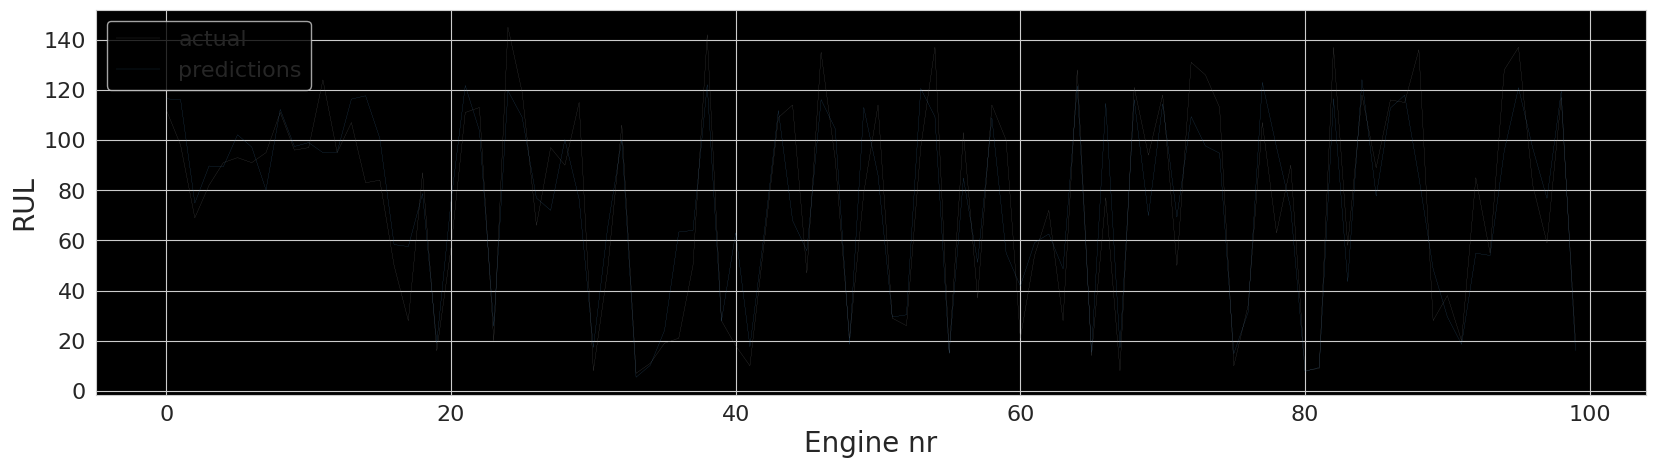

In [115]:
plt.rcParams['figure.figsize']=20,5

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

#Support Vector Machine

*Training a Support Vector Machine (SVM) regressor with an RBF kernel involves setting up and fitting the model with the appropriate hyperparameters.*

In [116]:
start = time.time()
model = SVR(kernel="rbf", C=100, gamma=0.5, epsilon=0.01).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['SVM'] = [model.score(X_test,y_test),
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 78.13%
Root Mean Squared Error: 19.43


*Creating a scatter plot to visualize the relationship between the actual RUL (y_test) and the predicted RUL (y_predictions), providing insights into how well the SVM regressor model is performing on the test data.*

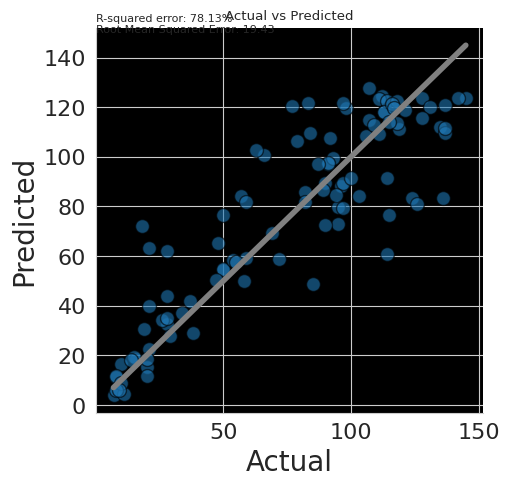

In [117]:
plt.rcParams['figure.figsize']=5,5
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
plt.rcParams['legend.fontsize']=16

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

*Creating a line plot to visualize the actual and predicted RUL values across different engines.*

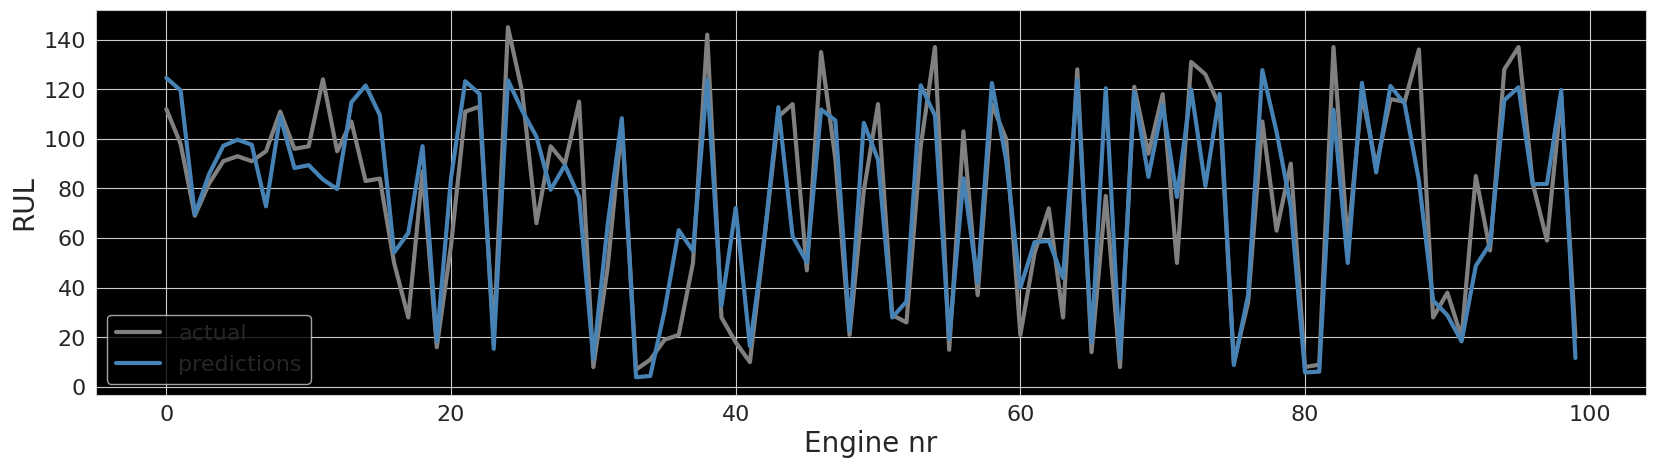

In [118]:
plt.rcParams['figure.figsize']=20,5

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

#Random Forest Regressor

*Using a RandomForestRegressor to predict RUL values and evaluating its performance.*

In [119]:
start = time.time()
model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=1,
                              max_features='sqrt',
                             ).fit(X_train,y_train)
end_train = time.time()
y_predictions = model.predict(X_test) # These are the predictions from the test data.
end_predict = time.time()

model_performance.loc['Random Forest'] = [model.score(X_test,y_test),
                                   mean_squared_error(y_test,y_predictions,squared=False),
                                   end_train-start,
                                   end_predict-end_train,
                                   end_predict-start]

print('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)))
print('Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False)))

R-squared error: 81.16%
Root Mean Squared Error: 18.04


*Creating a scatter plot to visualize the actual vs predicted RUL values using seaborn generated by the Random Forest model.*

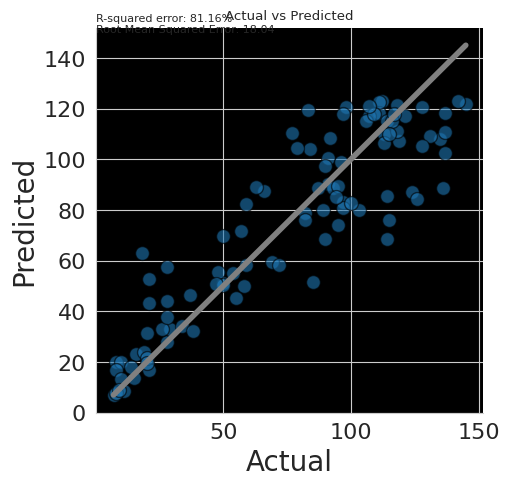

In [120]:
plt.rcParams['figure.figsize']=5,5

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(model.score(X_test,y_test)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

*Creating a line plot comparing the actual and predicted RUL values across different engines. This plot will visualize the trend of actual and predicted RUL values across different engine numbers, allowing to compare how well the model predicts RUL for each engine in the dataset.*

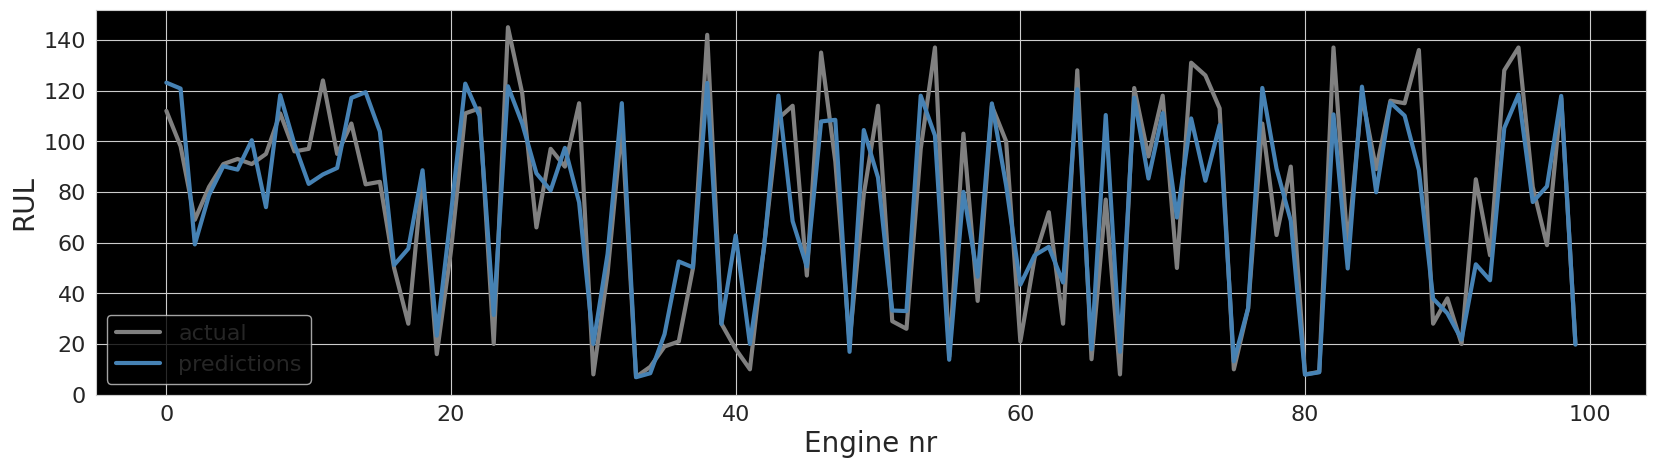

In [121]:
plt.rcParams['figure.figsize']=20,5

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

#Long - Short Term Memory

*Building a sequential LSTM model using Keras. The setup creates a stacked LSTM model suitable for sequence prediction like predicting remaining useful life (RUL) based on time series data.*

In [122]:
model = keras.Sequential()
model.add(LSTM(100,
                return_sequences=True,
               input_shape=(1,X_train.shape[1])
              ))
model.add(BatchNormalization())
model.add(LSTM(50,
                return_sequences=True,
               activation='tanh'
              ))
model.add(Dropout(0.5))
model.add(LSTM(10,
               return_sequences=True,
               activation='tanh',
              ))
model.add(Dropout(0.5))
model.add(Dense(100,
               activation='relu',
              ))
model.add(Dense(1))

*Then we set up a learning rate schedule using ExponentialDecay from TensorFlow's optimizers.schedules module.*

In [123]:
initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

*The below code compiles a Keras sequential model with mean squared error (MSE) as the loss function and Adam optimizer with a specified learning rate of 0.001. The summary will provide detailed information about each layer, including the output shape, number of parameters, and the activation function used (if applicable). This will show the layers, their types, output shapes, and the number of trainable parameters.*

In [124]:
model.compile(loss = "mse", optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 1, 100)            46400     
                                                                 
 batch_normalization_2 (Bat  (None, 1, 100)            400       
 chNormalization)                                                
                                                                 
 lstm_7 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_4 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_8 (LSTM)               (None, 1, 10)             2440      
                                                                 
 dropout_5 (Dropout)         (None, 1, 10)             0         
                                                      

*The ReduceLROnPlateau callback in Keras is used to reduce the learning rate when a metric has stopped improving. During training, ReduceLROnPlateau monitors the val_loss (validation loss) after every epoch. If no improvement is observed in val_loss for patience number of epochs, it adjusts the learning rate by factor (reducing it by a factor of factor). This reduction continues until either min_lr is reached or until training stops.*

In [125]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=4, min_lr=1e-7, verbose=1)

*Reshaping data to fit an LSTM model's input shape. After reshaping, we have fed X_train_reshaped and X_val_reshaped directly into LSTM model for training and validation, respectively. Similarly, X_test_reshaped will be used for making predictions after training. This helps to utilize LSTM effectively for sequential data prediction tasks such as predicting Remaining Useful Life (RUL).*

In [126]:
X_train_s, X_val, y_train_s, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train_reshaped = X_train_s.reshape(X_train_s.shape[0], 1, X_train_s.shape[1])
X_val_reshaped = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
X_test_reshaped = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

*Below code ensures to correctly handle predictions and evaluate LSTM model's performance on the test set.*

In [127]:
start = time.time()
history = model.fit(x=X_train_reshaped,y=y_train_s,
                    validation_data = (X_val_reshaped,y_val),
                    epochs = 50,
                    batch_size = 500,
                    callbacks=[reduce_lr]
                   )
end_train = time.time()
y_predictions = model.predict(X_test_reshaped).flatten()

end_predict = time.time()

# Evaluate model performance
r2 = sklearn.metrics.r2_score(y_test, y_predictions)
rmse = mean_squared_error(y_test, y_predictions, squared=False)

model_performance.loc['LSTM'] = [r2,
                                 rmse,
                                 end_train-start,
                                 end_predict-end_train,
                                 end_predict-start]

print('R-squared error: '+ "{:.2%}".format(r2))
print('Root Mean Squared Error: '+ "{:.2f}".format(rmse))

Epoch 1/50
38/38 [==============================] - 15s 59ms/step - loss: 9208.1270 - val_loss: 9274.0967 - lr: 0.0010
Epoch 2/50
38/38 [==============================] - 1s 22ms/step - loss: 8695.8047 - val_loss: 8185.2480 - lr: 0.0010
Epoch 3/50
38/38 [==============================] - 1s 35ms/step - loss: 7358.1938 - val_loss: 6273.3667 - lr: 0.0010
Epoch 4/50
38/38 [==============================] - 1s 36ms/step - loss: 5399.8110 - val_loss: 4362.9595 - lr: 0.0010
Epoch 5/50
38/38 [==============================] - 1s 28ms/step - loss: 3577.7139 - val_loss: 2827.6565 - lr: 0.0010
Epoch 6/50
38/38 [==============================] - 1s 20ms/step - loss: 2282.6997 - val_loss: 1856.4609 - lr: 0.0010
Epoch 7/50
38/38 [==============================] - 1s 21ms/step - loss: 1548.4233 - val_loss: 1018.0368 - lr: 0.0010
Epoch 8/50
38/38 [==============================] - 1s 20ms/step - loss: 1244.7174 - val_loss: 1172.0084 - lr: 0.0010
Epoch 9/50
38/38 [==============================] - 1s 

*Visualizing the actual vs predicted values after training your LSTM model.This plot will help to visualize how well LSTM model's predictions align with the actual values, along with providing quantitative metrics directly on the plot.*

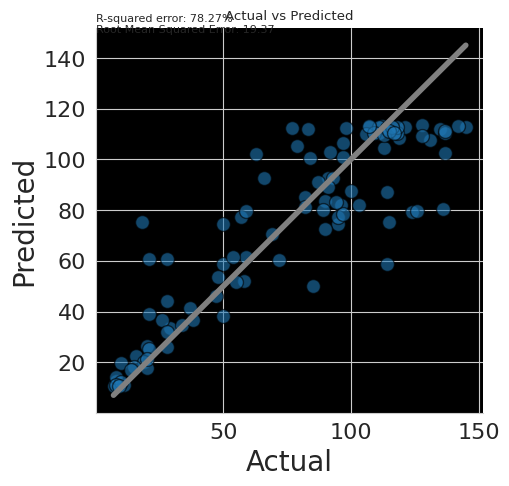

In [128]:
plt.rcParams['figure.figsize']=5,5

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=y_test,
                y=y_predictions,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(y_test),max(y_test)],
             y=[min(y_test),max(y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

plt.annotate(text=('R-squared error: '+ "{:.2%}".format(sklearn.metrics.r2_score(y_test, y_predictions)) +'\n' +
                  'Root Mean Squared Error: '+ "{:.2f}".format(mean_squared_error(y_test,y_predictions,squared=False))),
             xy=(0,150),
             size='medium')

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

*Plotting the line plot comparing actual and predicted RUL (Remaining Useful Life) across different engines, ensuring all engines are represented sequentially on the x-axis. This plot will show how well predictions align with the actual RUL values across different engines, providing a visual comparison between the two datasets.*

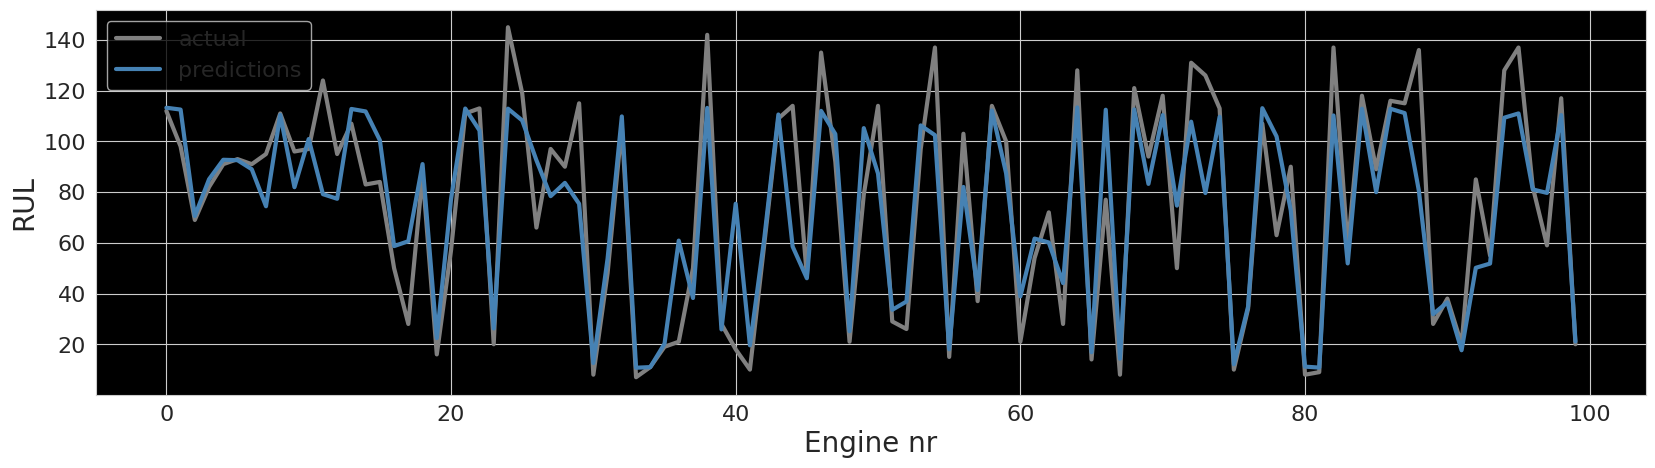

In [129]:
plt.rcParams['figure.figsize']=20,5

fig,ax = plt.subplots()
plt.ylabel('RUL')
plt.xlabel('Engine nr')

g = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_test,
                color='gray',
                label = 'actual',
                ax=ax)

f = sns.lineplot(x = np.arange(0,len(df_train['engine'].unique())),
                y=y_predictions,
                color='steelblue',
                label = 'predictions',
                ax=ax)
ax.legend()

*This plot will show how the training loss and validation loss evolved over epochs during the training of your LSTM model.*

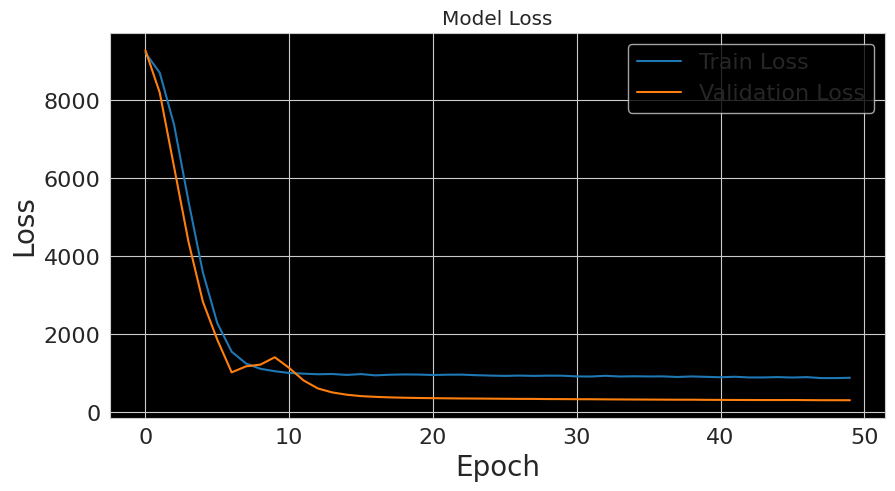

In [130]:
plt.rcParams['figure.figsize'] = 10, 5
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.size'] = 12
plt.rcParams['lines.linewidth'] = 1.5

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

*This combination of .style.background_gradient and .format provides a visually appealing and informative representation of model_performance DataFrame, making it easier to interpret the model's performance metrics.*

In [131]:
model_performance.style.background_gradient(cmap='RdYlBu_r').format({
    'R2': '{:.2%}',
    'RMSE': '{:.2f}',
    'time to train': '{:.3f}',
    'time to predict': '{:.3f}',
    'total time': '{:.3f}'
})

,R2,RMSE,time to train,time to predict,total time
kNN,79.79%,18.68,0.099,0.070,0.169
SVM,78.13%,19.43,30.828,0.131,30.958
Random Forest,81.16%,18.04,23.749,0.128,23.877
LSTM,78.27%,19.37,61.426,1.415,62.841
